In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import json
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.metrics import f1

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

In [5]:
f_model = resnet34
PATH = 'data/iMaterialist/'
sz=224

In [6]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
val_idxs = get_cv_idxs(30000)
data = ImageClassifierData.from_csv(PATH, 'train_30k', f'{PATH}train_30k_labels.csv', tfms=tfms, val_idxs=val_idxs, suffix='.jpg', test_name='test')

In [7]:
learn = ConvLearner.pretrained(f_model, data, precompute=True, metrics=[f1])

## Step 1

First we begin retraining the last layer to map training images to our new labels. Because we do not need to send images through all but the last layer more than once, we turn on precompute to cache the vector embeddings before training the last fully connected logistic regression layer.

epoch      trn_loss   val_loss   f1         
    0      0.273756   0.491502   0.285726  



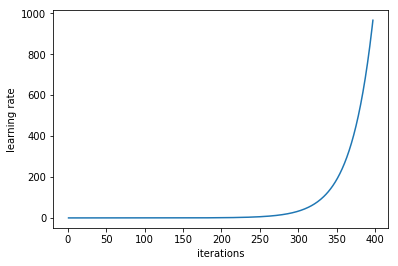

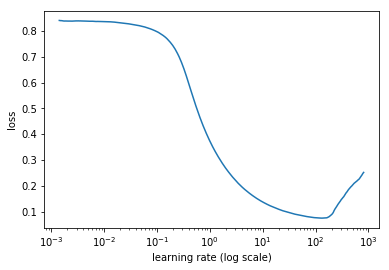

In [8]:
learn.lr_find(start_lr=1e-3, end_lr=1e3)
learn.sched.plot_lr()
plt.show()
learn.sched.plot()
plt.show()

We started to see overfitting after 4 epochs. We will stop this initial training at 4 epochs

In [9]:
learn.fit(10, 4)

epoch      trn_loss   val_loss   f1         
    0      0.04677    0.043123   0.383434  
    1      0.044483   0.041788   0.405559  
    2      0.04342    0.041107   0.384514  
    3      0.042519   0.041012   0.402765  



[array([0.04101]), 0.40276488050826487]

In [10]:
learn.fit(10, 6)

epoch      trn_loss   val_loss   f1         
    0      0.042411   0.040457   0.408852  
    1      0.04139    0.039999   0.422205  
    2      0.040895   0.039787   0.423136  
    3      0.040352   0.039654   0.436099  
    4      0.040093   0.03943    0.43706   
    5      0.040067   0.039714   0.421312  



[array([0.03971]), 0.4213122446405103]

## Step 2

Lets turn off precompute so we can use randomized crops / brightness levels / zooms for side-on image transformations. We will also add in some cycling of learning rates

In [11]:
learn.precompute=False

In [12]:
learn.fit(10, 1, cycle_len=1)

epoch      trn_loss   val_loss   f1         
    0      0.039963   0.038828   0.431366  



[array([0.03883]), 0.43136648167725083]

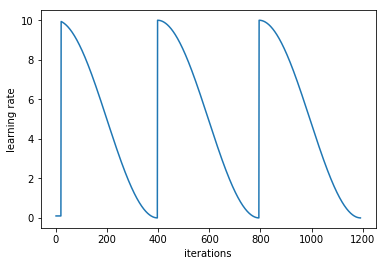

In [19]:
learn.sched.plot_lr()

## Step 3

Let's now tune the beginning, middle, and last layers with a couple more epochs and multiple the cycle len

 96%|█████████▌| 382/397 [01:24<00:03,  4.51it/s, loss=0.16] 

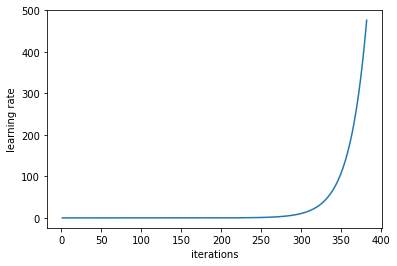

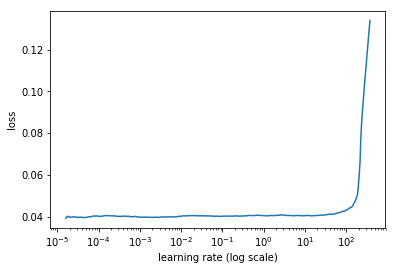

In [20]:
learn.lr_find(start_lr=1e-5, end_lr=1e3)
learn.sched.plot_lr()
plt.show()
learn.sched.plot()
plt.show()

In [13]:
learn.unfreeze()
lr=np.array([0.1, 1.0, 10.0])
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   f1         
    0      0.03927    0.037464   0.453202  
    1      0.038001   0.036704   0.469364  
    2      0.03687    0.036364   0.479221  



[array([0.03636]), 0.47922149395452157]

In [14]:
lr=np.array([1.0, 3.0, 10.0])
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   f1         
    0      0.037921   0.036628   0.473794  
    1      0.036964   0.03613    0.483662  
    2      0.035994   0.035975   0.485593  



[array([0.03598]), 0.485593055289795]

In [15]:
learn.save('resnet34_train_30k_0.485593')

# Load Model and score on test data

In [16]:
multi_preds, y = learn.TTA(is_test=True)
preds = np.mean(multi_preds, 0)

This generates a label for each multilabel where score > 0.5

In [17]:
def save_results_to_csv(model, preds, threshold):
    cs = np.array(model.data.classes)
    label_preds = list(map(lambda x: ' '.join(cs[x]), (preds > threshold)))
    test_ids = list(map(lambda x: int(x[5:-4]), model.data.test_ds.fnames))
    
    pred_df = (
        pd.DataFrame(list(zip(test_ids, label_preds)),
                     columns=['image_id', 'label_id'])
        .sort_values('image_id')
        .reset_index(drop=True)
    )
    
    with open('data/iMaterialist/test.json') as f:
        test_urls = pd.DataFrame(json.load(f)['images'])

    with open('data/iMaterialist/validation.json') as f:
        j = json.load(f)
        valid_urls = pd.DataFrame(j['images'])
        valid_labels = pd.DataFrame(j['annotations'])
        valid_labels['labelId'] = valid_labels['labelId'].apply(lambda x: ' '.join(x))
        valid = valid_urls.merge(valid_labels, how='inner', on='imageId')[['url', 'labelId']]
    test_labels = test_urls.merge(valid, how='inner', on='url').drop('url', axis=1)
    
    pred_df.loc[:9896, 'label_id'] = test_labels['labelId'].values
    pred_df.to_csv(f'data/iMaterialist/submission_resnet34_train_30k_0.485593_t_{str(threshold)}.csv', index=False)
    

In [20]:
save_results_to_csv(learn, preds, 0.3)